# Imports
Importing necessary packages and modules

In [0]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

# Data Preparation

Parse the JSON file to obtain annotations.

<br/>

### JSON File Structure

The annotation file will be of COCO format and have the following structure
- **images**
  - **id**: Image id
  - **width**: Width of the image
  - **height**: Height of the image
  - **filename**: Image file name
  - **license**: License id for the image
  - **date_captured**: Date of capture of the image
- **annotations**
  - **id**: Annotation id
  - **image_id**: Id of the image the annotation is associated with
  - **category_id**: Id of the class the annotation belongs to
  - **segmentation**: (x, y) coordinates of the four corners of the bounding box
  - **area**: Area of the bounding box
  - **bbox**: (x, y) coordinate of the top-left corner and width and height of the bounding box
  - **iscrowd**: If the image has a crowd of objects denoted by this annotation

In [0]:
def load_json(path):
    """Read the input JSON file.

    Args:
        path (str): Path to the JSON file.
    
    Returns:
        Image annotations.
    """
    with open(path) as f:
        img_annotations = eval(f.read())
    return img_annotations

In [0]:
def fetch_data_points(img_annotations):
    """Fetch data points from the image
    annotations.

    Args:
        img_annotations (dict): Image annotations.
    
    Returns:
        Array containing data points.
    """
    data_points = []
    for annotation in img_annotations['annotations']:
        bbox = annotation['bbox']
        img = img_annotations['images'][int(annotation['image_id'])]

        # Normalize the height and width of the bounding box
        data_points.append((
            bbox[2] / img['width'],
            bbox[3] / img['height']
        ))
    return np.array(data_points)

In [0]:
img_annotations = load_json('dogs.json')
data_points = fetch_data_points(img_annotations)

## Visualize Data

Display a scatter plot of the height and width of the normalized bounding boxes

Text(0, 0.5, 'height')

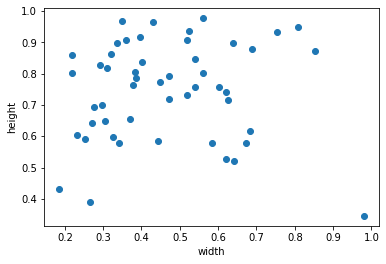

In [5]:
plt.scatter(data_points[:, 0], data_points[:, 1])
plt.xlabel('width')
plt.ylabel('height')

Display a scatter plot of the log of height and width of the normalized bounding boxes

Text(0, 0.5, 'log(height)')

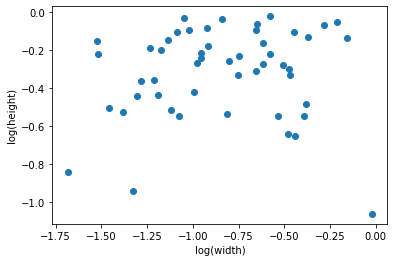

In [6]:
plt.scatter(np.log(data_points[:, 0]), np.log(data_points[:, 1]))
plt.xlabel('log(width)')
plt.ylabel('log(height)')

# K-Means Clustering

Define the K-Means algorithm

In [0]:
class KMeans:
    """K-Means clustering algorithm."""

    def __init__(self, num_clusters, points, iterations):
        """Initialize parameters of the algorithm.

        Args:
            num_clusters (int): Number of clusters to
                segment the data into.
            points (numpy.ndarray): Points in the dataset.
            iterations (int): Number of iterations for
                running the algorithm.
        """
        self.num_clusters = num_clusters
        self.points = points
        self.iterations = iterations

        self.centroids = self.initialize_centroids()
        self.closest = None
        self.mean_iou = None

        self.find_clusters()
        self.iou()

    def initialize_centroids(self):
        """Select random inital centroids from the points.
        
        Returns:
            Array containing initial centroids.
        """
        centroids = self.points.copy()
        np.random.shuffle(centroids)
        return centroids[:self.num_clusters]

    def closest_centroid(self):
        """Find the closest centroid for each point in the dataset."""
        distances = np.sqrt(
            ((self.points - self.centroids[:, np.newaxis]) ** 2).sum(axis=2)
        )
        self.closest = np.argmin(distances, axis=0)

    def move_centroids(self):
        """Find new centroids based on the points in the cluser."""
        self.centroids =  np.array([
            self.points[self.closest == k].mean(axis=0)
            for k in range(self.centroids.shape[0])
        ])
    
    def find_clusters(self):
        """Run the K-Means algorithm."""
        for _ in range(self.iterations):
            self.closest_centroid()
            self.move_centroids()
    
    def iou(self):
        """Calculate Intersection over Union (IoU) for each point
        with its closest centroid."""
        closest_centroids = self.centroids[self.closest]
        width = np.minimum(
            closest_centroids[:, 0], self.points[:, 0]
        )
        height = np.minimum(
            closest_centroids[:, 1], self.points[:, 1]
        )

        intersection = width * height
        points_area = self.points[:, 0] * self.points[:, 1]
        cluster_area = closest_centroids[:, 0] * closest_centroids[:, 1]

        self.mean_iou = np.mean(
            intersection / (points_area + cluster_area - intersection)
        )

Run the algorithm for a number of clusters ranging from 1 to 18. Store the mean IoU for each cluster in a list.

In [0]:
# List containing the mean IoU for each set of
# number of clusters
iou_list = []
kmeans_model = {}

# Range of number of clusters to try out
num_clusters_start = 1
num_clusters_end = 16

# Number of iterations to run each pass
iterations = 300

# Run K-Means for each range of number of clusters
for k in range(num_clusters_start, num_clusters_end + 1):
    kmeans_model[k + 1] = KMeans(k + 1, data_points, iterations)
    iou_list.append(kmeans_model[k + 1].mean_iou)

## Visualize Results

Display the Number of clusters vs Mean IoU graph

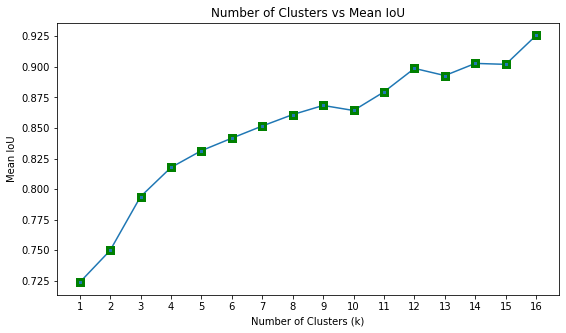

In [32]:
fig = plt.figure(figsize=(9, 5))

_ = plt.plot(iou_list, '-s', markeredgecolor='green', markeredgewidth=3)

plt.xlabel('Number of Clusters (k)')
plt.ylabel('Mean IoU')

plt.xticks(np.arange(len(iou_list)), np.arange(1, len(iou_list)+1))
plt.title('Number of Clusters vs Mean IoU')

fig.savefig('kmeans_iou.png')

For the above plot, k = 3 or k = 4 seems to be the best choice because for after 4, the curve becomes almost linear.

## Plot clusters

Let's display plots for points with k = 3 and k = 4

In [0]:
def display_clusters(kmeans):
    num_clusters = kmeans.num_clusters

    # Plot points for each cluster
    for cluster_id in range(num_clusters):
        points = kmeans.points[kmeans.closest == cluster_id]
        plt.scatter(points[:, 0], points[:, 1])
    
    # Plot centroids
    plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='black', s=90, marker='x')
    plt.xlabel('width')
    plt.ylabel('height')
    plt.title(f'Cluster Plot for k = {num_clusters}')

    # Save figure
    plt.savefig(f'cluster_plot_k{num_clusters}.png')

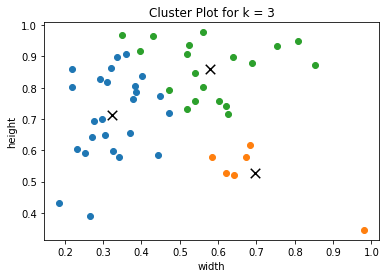

In [49]:
# Plot for k = 3
display_clusters(kmeans_model[3])

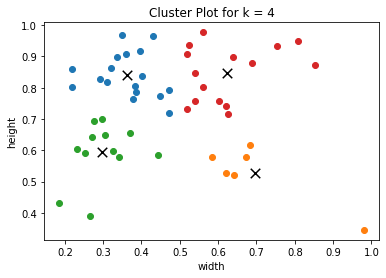

In [50]:
# Plot for k = 4
display_clusters(kmeans_model[4])

# Plot Anchor Boxes
Plot the anchor boxes obtained for k = 3 and k = 4

In [0]:
def make_anchor_boxes(ax, clusters, edgecolor='b', alpha=1):
    """Make anchor boxes given cluster centroids."""

    xdata = np.array([0.5]*len(clusters))
    ydata = np.array([0.5]*len(clusters))

    xerror = np.array([list(np.exp(clusters[:, 0])/2)]*2)
    yerror = np.array([list(np.exp(clusters[:, 1])/2)]*2)

    # Create list for all the error patches
    errorboxes = []

    # Loop over data points; create box from errors at each point
    for x, y, xe, ye in zip(xdata, ydata, xerror.T, yerror.T):
        rect = Rectangle((x - xe[0], y - ye[0]), xe.sum(), ye.sum())
        errorboxes.append(rect)

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(
        errorboxes, facecolor='None', alpha=alpha, edgecolor=edgecolor
    )

    # Add collection to axes
    ax.add_collection(pc)

    # Plot errorbars
    artists = ax.errorbar(
        xdata, ydata, xerr=xerror, yerr=yerror, fmt='None', ecolor='None'
    )

    return artists

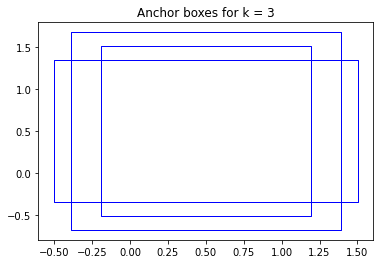

In [41]:
# Create figure and axes
fig, ax = plt.subplots(1)

# Create error boxes
_ = make_anchor_boxes(ax, kmeans_model[3].centroids)

# Show plot
plt.title('Anchor boxes for k = 3')
plt.show()
fig.savefig('anchor_bbox_k3.png')

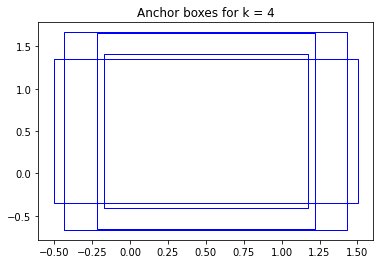

In [42]:
# Create figure and axes
fig, ax = plt.subplots(1)

# Create error boxes
_ = make_anchor_boxes(ax, kmeans_model[4].centroids)

# Show plot
plt.title('Anchor boxes for k = 4')
plt.show()
fig.savefig('anchor_bbox_k4.png')